In [ ]:

!sudo apt-get update -y
!sudo apt-get install -y openjdk-21-jdk

import os, subprocess, sys, textwrap, re, json, pathlib
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-21-openjdk-amd64"
os.environ["PATH"] = os.environ["JAVA_HOME"] + "/bin:" + os.environ["PATH"]
!java -version          # should show 21.0.x


In [ ]:
!pip install --upgrade pip
!pip install r5py


In [ ]:

import pandas as pd
import geopandas as gpd
from shapely.geometry import Point
import datetime as dt

import numpy as np
import matplotlib.pyplot as plt
!pip install contextily
import contextily as cx
from shapely.ops import unary_union




In [4]:
!unzip -qq MBTA_GTFS.zip -d mbta_tmp

!rm mbta_tmp/transfers.txt

!cd mbta_tmp && zip -qr ../MBTA_GTFS_clean.zip .
!rm -rf mbta_tmp


In [5]:
# download https://download.geofabrik.de/north-america/us/massachusetts.html
# and download https://www.mbta.com/developers/gtfs


import r5py
tn = r5py.TransportNetwork("massachusetts-latest.osm.pbf", "MBTA_GTFS_clean.zip")



In [7]:
dep_time = dt.datetime(2025, 5, 26, 12, 36)
departure_time_window_ =dt.timedelta(minutes=10)
max_time_walking_ = dt.timedelta(minutes=120)
max_time_= dt.timedelta(minutes=120)

origin_pt      = Point( -71.11155200510271,42.321369230712136)
destination_pt = Point( -71.05967613337238	,42.36010463783354)

origins = gpd.GeoDataFrame({"id":[0], "geometry":[origin_pt]},      crs="EPSG:4326")
dests   = gpd.GeoDataFrame({"id":[1], "geometry":[destination_pt]}, crs="EPSG:4326")

results = r5py.DetailedItineraries(
        transport_network = tn,
        origins           = origins,
        destinations      = dests,
        departure         = dep_time,
        departure_time_window = departure_time_window_,
        transport_modes   = ["TRANSIT",'WALK'],   # ← no pure-walk fall-back
        access_modes      = ["WALK"],      # walk to the stop
        egress_modes      = ["WALK"],
        max_time_walking  = max_time_walking_,
        max_time          = max_time_,   # enlarge if needed
        snap_to_network   = False,
)

results_ = results[['travel_time','wait_time','option']].groupby('option').sum()
results_['total'] = results_['travel_time']+results_['wait_time']
opt = results_.sort_values('total').index[0]

times = np.sum(results[results['option']==opt].travel_time)+np.sum(results[results['option']==opt].wait_time)
distances = np.sum(results[results['option']==opt]['distance'])
geometr= unary_union(results[results['option']==opt].geometry)


In [20]:
print('total time:', round(times.total_seconds()/60,2), 'minutes')
print('total distance:', round(distances,2), 'meters')

total time: 36.97 minutes
total distance: 7087.78 meters


In [22]:
results[results['option']==opt]

,from_id,to_id,option,segment,transport_mode,departure_time,distance,travel_time,wait_time,feed,agency_id,route_id,start_stop_id,end_stop_id,geometry
206,0,1,58,0,TransportMode.WALK,2025-05-26 12:38:38,81.331000,0 days 00:01:16,0 days 00:00:00,None,None,None,None,None,"LINESTRING (-71.11022 42.32184, -71.11025 42.3..."
207,0,1,58,1,TransportMode.BUS,2025-05-26 12:41:00,4171.813312,0 days 00:18:00,0 days 00:01:06,mbta-ma-us,1,39,6570,11389,"LINESTRING (-71.1121 42.32169, -71.1121 42.321..."
208,0,1,58,2,TransportMode.WALK,2025-05-26 13:00:00,33.463000,0 days 00:00:34,0 days 00:01:01,None,None,None,None,None,"LINESTRING (-71.08154 42.34534, -71.08148 42.3..."
209,0,1,58,3,TransportMode.TRAM,2025-05-26 13:01:00,2705.511914,0 days 00:12:00,0 days 00:01:25,mbta-ma-us,1,Green-E,70240,70201,"LINESTRING (-71.08162 42.34538, -71.08157 42.3..."
210,0,1,58,4,TransportMode.WALK,2025-05-26 13:14:00,95.664000,0 days 00:01:36,0 days 00:00:00,None,None,None,None,None,"LINESTRING (-71.05922 42.3597, -71.05922 42.35..."


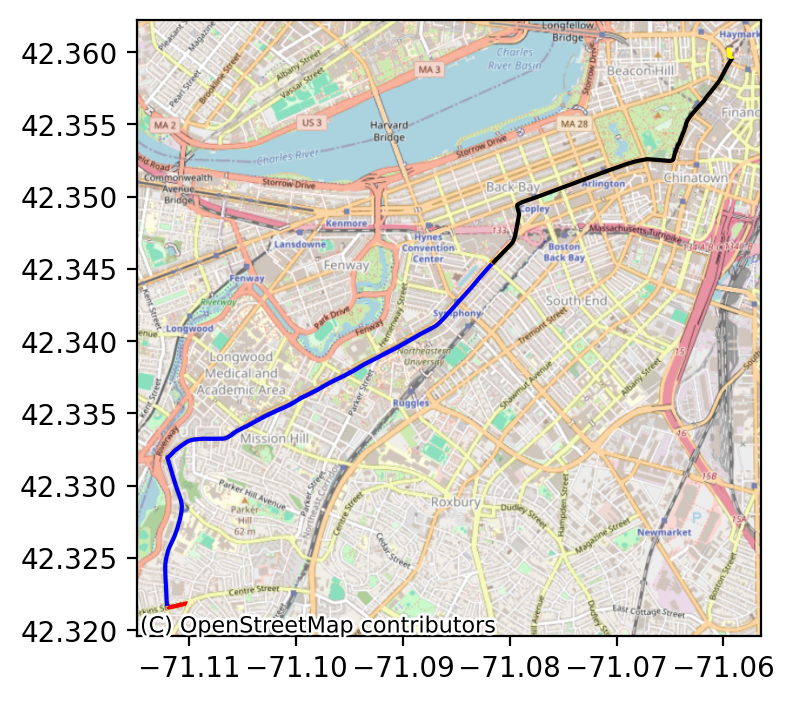

In [8]:

fig, ax = plt.subplots(figsize = (6,4),dpi=200)
colors=['red','blue','orange','black','yellow','red','black']
for k in range(len(results[results['option']==opt])):
  results[results['option']==opt].iloc[k:k+1].geometry.plot(ax=ax,color=colors[k])

cx.add_basemap(ax, crs=4269,source=cx.providers.OpenStreetMap.Mapnik)
